# 06 - Grouped and Dummy Regression


## 그룹화된 데이터를 사용한 회귀

모든 데이터 포인트가 동일하게 생성되는 것은 아닙니다. ENEM 데이터 세트를 다시 보면 작은 규모의 학교 점수보다 큰 큐모의 학교 점수를 훨씬 더 신뢰합니다. 이것은 큰 규모의 학교가 더 낫다는 것이 아닙니다. 그냥 크기가 클수록 분산이 작기 때문입니다.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf

style.use("fivethirtyeight")

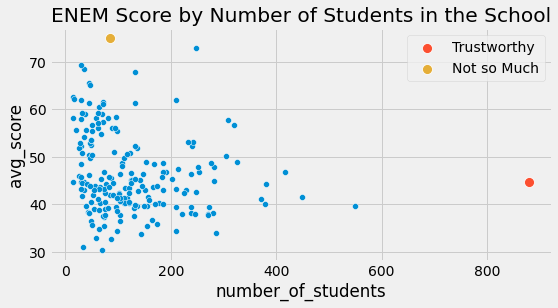

In [ ]:
np.random.seed(876)
enem = pd.read_csv("./data/enem_scores.csv").sample(200)
plt.figure(figsize=(8,4))
sns.scatterplot(y="avg_score", x="number_of_students", data=enem)
sns.scatterplot(y="avg_score", x="number_of_students", s=100, label="Trustworthy",
                data=enem.query(f"number_of_students=={enem.number_of_students.max()}"))
sns.scatterplot(y="avg_score", x="number_of_students", s=100, label="Not so Much",
                data=enem.query(f"avg_score=={enem.avg_score.max()}"))
plt.title("ENEM Score by Number of Students in the School");

위의 데이터에서 직관적으로 왼쪽 점이 오른쪽 점보다 모형에 미치는 영향이 적어야 합니다. 기본적으로 오른쪽 점은 실제 단일 항목으로 그룹화된 많은 여러 데이터들의 점입니다. 우리가 그것들을 묶지 않고 그룹화되지 않은 데이터로 선형 회귀 분석을 실행할 수 있다면, 실제로 왼쪽의 묶이지 않은 점보다 오른쪽 점이 모델 추정에 훨씬 더 많은 기여를 할 것입니다. 

분산이 낮은 영역과 분산이 높은 영역을 동시에 갖는 이러한 현상을 **이분산성** 이라고 합니다. 간단히 말해서 이분산성은 변수의 모든 값에서 분산이 일정하지 않은 경우입니다. 위의 경우 변수 샘플 크기가 증가함에 따라 분산이 감소하는 것을 볼 수 있습니다. 이분산성이 있는 또 다른 예를 들자면, 임금을 연령별로 도표화하면 젊은이보다 노인의 임금 편차가 더 크다는 것을 알 수 있습니다. 그러나 분산이 달라지는 가장 일반적인 이유는 그룹화된 데이터 때문입니다.

위와 같은 그룹화된 데이터는 데이터 분석에서 매우 일반적입니다. 그것에 대한 한 가지 이유는 기밀성입니다. 정부와 기업은 따라야 하는 데이터 개인 정보 보호 요구 사항을 위반하기 때문에 개인 데이터를 제공할 수 없습니다. 외부 연구자에게 데이터를 내보내야 하는 경우 데이터를 그룹화하는 방법으로만 내보낼 수 있습니다. 이러한 방식으로, 개인은 그룹화되어 더 이상 고유하게 식별할 수 없습니다.

다행스럽게도 회귀는 이러한 종류의 데이터를 꽤 잘 처리할 수 있습니다. 그 방법을 이해하기 위해, 먼저 임금 및 교육에 대한 데이터와 같은 그룹화되지 않은 데이터를 살펴보겠습니다. 여기에는 근로자 한 명당 한 줄씩을 포함하고 있기 때문에, 이 데이터 세트에서 각 개인에 대한 임금과 교육 기간 정보를 알 수 있습니다.

In [ ]:
wage = pd.read_csv("./data/wage.csv")[["wage", "lhwage", "educ", "IQ"]]

wage.head()

wage    lhwage  educ   IQ
0   769  2.956212    12   93
1   808  2.782539    18  119
2   825  3.026504    14  108
3   650  2.788093    12   96
4   562  2.642622    11   74

교육이 로그 시간당 임금과 어떻게 연관되어 있는지 알아보기 위해 회귀 모델을 실행하면 다음과 같은 결과를 얻을 수 있습니다.

In [ ]:
model_1 = smf.ols('lhwage ~ educ', data=wage).fit()
model_1.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

자, 잠시 이 데이터가 어떤 기밀성의 제약을 받고 있다고 가정해 보겠습니다. 제공자는 개별화된 데이터를 제공할 수 없었습니다. 그래서 우리는 대신 그에게 교육을 받은 모든 사람을 그룹화하고 평균 로그 시간당 임금과 각 그룹의 개인 수만 알려달라고 요청합니다. 이렇게 하면 10개의 데이터 포인트만 남게 됩니다.

In [ ]:
group_wage = (wage
              .assign(count=1)
              .groupby("educ")
              .agg({"lhwage":"mean", "count":"count"})
              .reset_index())

group_wage

educ    lhwage  count
0     9  2.856475     10
1    10  2.786911     35
2    11  2.855997     43
3    12  2.922168    393
4    13  3.021182     85
5    14  3.042352     77
6    15  3.090766     45
7    16  3.176184    150
8    17  3.246566     40
9    18  3.144257     57

두려워하지 마세요! 회귀 분석에는 빅 데이터가 필요하지 않습니다! 우리가 할 수 있는 것은 선형 회귀 모델에 가중치를 제공하는 것입니다. 이런 식으로 소규모 그룹보다 표본 크기가 더 큰 그룹을 더 많이 고려합니다. 가중 최소 제곱에 대해 `smf.ols`를 `smf.wls`로 대체했습니다. 알아차리기 어렵지만, 그것이 모든 것을 변화시킬 것입니다.

In [ ]:
model_2 = smf.wls('lhwage ~ educ', data=group_wage, weights=group_wage["count"]).fit()
model_2.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

그룹화된 모델에서 `educ`의 모수 추정치가 그룹화되지 않은 데이터의 모수 추정치에 얼마나 가까운지 주목하십시오(실제로, 이 경우 동일gka). 또한 데이터 포인트가 10개밖에 없어도 통계적으로 유의미한 계수를 얻을 수 있었습니다. 포인트가 더 적지만, 그룹화하면 분산도 많이 줄어들기 때문입니다. 또한 표준 오차가 약간 더 크고 t 통계량이 약간 더 크다는 점에 유의하십시오. 분산에 대한 일부 정보가 손실되기 때문에 좀 더 보수적이어야 하기 때문입니다. 데이터를 그룹화하면 각 그룹 내에서 분산이 얼마나 큰지 알 수 없습니다. 위의 결과를 가중치가 없는 모델로 얻은 결과과 비교해봅시다.

In [ ]:
model_3 = smf.ols('lhwage ~ educ', data=group_wage).fit()
model_3.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

모수 추정치가 더 작습니다. 여기서 일어나고 있는 일은 회귀 분석에서 모든 점에 동일한 가중치를 부여하고 있다는 것입니다. 그룹화된 점을 따라 모델을 플로팅하면 가중치가 없는 모델이 왼쪽 하단의 작은 점에 더 많은 중요성을 부여하고 있음을 알 수 있습니다. 결과적으로 선은 더 낮은 기울기를 갖습니다.

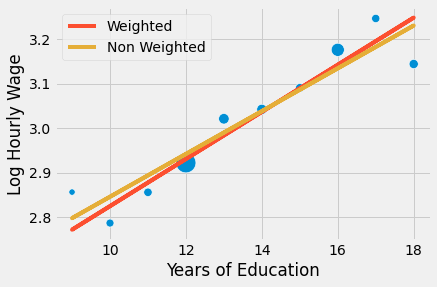

In [ ]:
sns.scatterplot(x="educ", y = "lhwage", size="count", legend=False, data=group_wage, sizes=(40, 400))
plt.plot(wage["educ"], model_2.predict(wage["educ"]), c="C1", label = "Weighted")
plt.plot(wage["educ"], model_3.predict(wage["educ"]), c="C2", label = "Non Weighted")
plt.xlabel("Years of Education")
plt.ylabel("Log Hourly Wage")
plt.legend();

결론적으로 회귀는 개별 데이터나 집계된 데이터 모두에서 작동하는 이 훌륭한 도구이지만, 이 마지막 경우에는 가중치를 사용해야 합니다. 가중 회귀 분석을 사용하려면 평균 통계량이 필요합니다. 합, 표준 편차, 중위수가 아니라 평균입니다! 공변량 및 종속 변수 모두에 대해 사용합니다. 그룹화 데이터를 사용한 가중 회귀 분석의 결과는 그룹화되지 않은 데이터의 회귀 분석과 정확히 일치하지는 않지만 꽤 유사할 것입니다.

![img](https://matheusfacure.github.io/python-causality-handbook/_images/heterosk.png)

그룹화된 데이터 모델에서 추가 공변량을 사용하는 마지막 예제로 마무리하겠습니다.

In [ ]:
group_wage = (wage
              .assign(count=1)
              .groupby("educ")
              .agg({"lhwage":"mean", "IQ":"mean", "count":"count"})
              .reset_index())

model_4 = smf.wls('lhwage ~ educ + IQ', data=group_wage, weights=group_wage["count"]).fit()
print("Number of observations:", model_4.nobs)
model_4.summary().tables[1]

Number of observations: 10.0


<class 'statsmodels.iolib.table.SimpleTable'>

이 예에서는 이전에 추가된 교육 기간 외에도 IQ를 변수로 포함했습니다. 구조는 거의 동일합니다. 평균과 카운트를 구하고 평균으로 회귀하고 카운트를 가중치로 사용합니다.

## Regression for Dummies

더미 변수는 이진 열로 인코딩한 범주형 변수입니다. 예를 들어, 모델에 포함하려는 성별 변수가 있다고 가정합니다. 이 변수는 남성, 여성 및 기타 성별의 세 가지 범주로 인코딩됩니다.

|gender|
|------|
|male  |
|female|
|female|
|other |
|male  |

우리 모델은 숫자 값만 허용하므로 이 범주를 숫자로 변환해야 합니다. 선형 회귀에서는 더미를 사용합니다. 각 변수를 범주의 존재를 나타내는 0/1 열로 인코딩합니다. 또한 범주 중 하나를 기본 범주로 남겨둡니다. 마지막 범주는 다른 범주의 선형 조합이기 때문에 이 작업이 필요합니다. 바꿔 말하면, 누군가 다른 사람의 정보를 주면 마지막 범주를 알 수 있습니다. 이 예에서, 누군가가 여성도 아니고 다른 성별도 아닌 경우, 그 사람의 범주가 남성이라고 추론할 수 있습니다.

|gender|female|other|
|------|:-----|:----|
|male  |0|0|
|female|1|0|
|female|1|0|
|other |0|1|
|male  |0|0|

우리는 이미 A/B 테스트를 다룰 때 간단한 형태의 더미 회귀 분석을 다루었습니다. 더 일반적으로, 우리가 이진 처치를 다룰 때 더미 변수로 표현합니다. 이 경우 **해당 더미에 대한 회귀 계수는 회귀선의 절편에 대한 증분** 또는 처치된 것과 처치되지 않은 것 간의 평균 차이입니다.

이를 보다 구체화하기 위해 12학년 졸업이 시급에 미치는 영향을 추정하는 문제를 고려하세요(지금은 교란 요인을 무시합시다). 아래 코드에서, 우리는 12년 이상의 교육을 받았는지를 나타내는 처치 더미 변수 `T`를 만들었습니다.

In [ ]:
wage = (pd.read_csv("./data/wage.csv")
        .assign(hwage=lambda d: d["wage"] / d["hours"])
        .assign(T=lambda d: (d["educ"] > 12).astype(int)))

wage[["hwage", "IQ", "T"]].head()

hwage   IQ  T
0  19.225   93  0
1  16.160  119  1
2  20.625  108  1
3  16.250   96  0
4  14.050   74  0

더미는 일종의 스위치 역할을 합니다. 이 예에서 더미가 켜져 있으면 예측 값은 절편에 더미 계수를 더한 값입니다. 더미가 꺼져 있으면 예측 값은 절편일 뿐입니다.

In [ ]:
smf.ols('hwage ~ T', data=wage).fit().summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

이 경우 12학년을 마치지 않았을 때 (dummy off) 평균 소득은 19.9입니다. 12학년을 마치면 (dummy on) 예상 가치 또는 평균 수입은 24.8449(19.9405 + 4.9044)입니다. 따라서 더미 계수는 4.9044인 평균의 차이를 포착합니다.

보다 형식적으로 독립 변수가 이진인 경우 처치 지표에서 흔히 볼 수 있듯이 회귀 분석에서는 ATE를 완벽하게 캡처합니다. 회귀는 조건부 기대 함수(CEF) $E[Y|X]$에 대한 선형 근사치이며, 이 경우 CEF는 선형이기 때문입니다. 즉, 우리는 다음 CEF

$
E[Y_i|T_i] =  E[Y_i|T_i=0] + \beta T_i = \alpha + \beta T_i
$

로 이끄는 $E[Y_i|T_i=0]=\alpha$ 와  $E[Y_i|T_i=1] = \alpha + \beta$를 정의할 수 있습니다.


그리고 $\beta$은 무작위 데이터의 경우 평균의 차이 또는 ATE입니다.

$
\beta = [Y_i|T_i=1] - [Y_i|T_i=0]
$

추가 변수를 사용하면 더미 계수가 평균의 **조건부** 차이가 됩니다. 예를 들어, 이전 모델에 IQ를 추가한다고 가정해 보겠습니다. 이제, **더미 계수는 IQ를 고정한 상태**에서 12학년을 졸업할 때 얼마나 많은 증가를 기대해야 하는지 알려줍니다. 예측을 플로팅하면 두 개의 평행선이 표시됩니다. 한 줄에서 다음 줄로 넘어가는 것은 우리가 12학년을 마치기 위해 기대되는 하는 금액을 나타냅니다. 그들은 또한 효과가 일정하다고 말합니다. IQ에 관계없이 모든 사람은 12학년을 졸업하면 동일한 혜택을 받습니다.

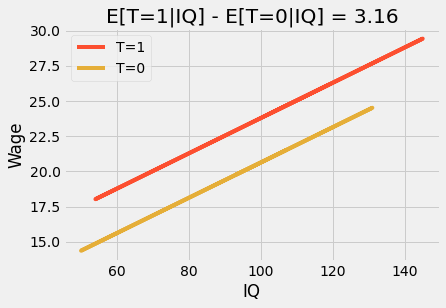

In [ ]:
m = smf.ols('hwage ~ T+IQ', data=wage).fit()
plt_df = wage.assign(y_hat = m.fittedvalues)

plt.plot(plt_df.query("T==1")["IQ"], plt_df.query("T==1")["y_hat"], c="C1", label="T=1")
plt.plot(plt_df.query("T==0")["IQ"], plt_df.query("T==0")["y_hat"], c="C2", label="T=0")
plt.title(f"E[T=1|IQ] - E[T=0|IQ] = {round(m.params['T'], 2)}")
plt.ylabel("Wage")
plt.xlabel("IQ")
plt.legend();

이 모델을 방정식에 넣으면 그 이유를 알 수 있습니다:

$
wage_i = \beta_0 + \beta_1T_i + \beta_2 IQ_i + e_i
$

여기서, $\beta_1$은 평균의 조건부 차이이며 상수 값이며 우리의 경우 3.16입니다. 교호작용 항을 추가하여 이 모델을 더 유연하게 만들 수 있습니다.

$
wage_i = \beta_0 + \beta_1T_i + \beta_2 IQ_i + \beta_3 IQ_i * T_i  + e_i
$

상황이 좀 더 복잡해지고 있으므로 이 모델에서 각 매개변수가 의미하는 바를 살펴보겠습니다. 먼저 $\beta_0$를 차단해보십시오. 이 나쁜 소년은 특별히 흥미로운 해석을 가지고 있지 않습니다. 처치가 0(12학년을 졸업하지 않은 사람)이고 IQ가 0점일 때 예상되는 임금입니다. IQ가 0일 것으로 예상하지 않기 때문에 이 매개 변수는 그다지 의미가 없습니다. $\beta_1$에 대해, 우리는 비슷한 상황을 가지고 있습니다. **이 매개변수는 IQ가 0일 때 **12학년을 마치면 예상되는 임금 인상폭입니다. 다시 한 번 말하지만, IQ는 결코 0이 아니므로, 그것은 특별히 흥미로운 의미가 없습니다. 이제 $\beta_2$가 조금 더 흥미롭습니다. **그것은 IQ가 처치받지 않은 사람들의 ** 임금을 얼마나 증가시키는지 알려줍니다. 그래서 우리의 경우 0.11 정도 됩니다. 이것은 IQ 점수 1점당, 12학년을 마치지 못한 사람은 시간당 11센트를 더 얻을 것으로 기대해야 한다는 것을 의미합니다. 마지막으로, 가장 흥미로운 매개 변수는 $\beta_3$입니다. 그것은 12학년을 졸업할 때 아이큐가 얼마나 증가하는지 알려줍니다. 우리의 경우, 이 매개변수는 0.024입니다. 즉, IQ 점수가 추가될 때마다 12학년을 졸업하면 2센트가 추가로 주어집니다. 이것은 별거 아닌 것처럼 보이지만 IQ가 60인 사람과 IQ가 140인 사람을 비교해 보십시오. 전자는 1.44달러(60x0.024)의 임금이 인상되는 반면, IQ가 140인 사람은 12학년을 졸업하면 3.36달러(140x0.024)를 추가로 받게 됩니다.

간단한 모델링 전문 용어에서 이 교호작용 항을 사용하면 처치 효과가 변수 수준별로 변경될 수 있습니다(이 예에서는 IQ만). 결과는 예측 선을 플로팅하면 더 이상 평행하지 않고 12학년을 졸업한 사람들이(T=1) IQ에서 더 높은 기울기를 가지며 낮은 IQ보다 높은 IQ일 때 졸업하면 더 많은 이점을 얻는다는 것을 알 수 있다는 것입니다. 이것은 때때로 효과 수정 또는 이질적인 처치 효과로 언급됩니다.

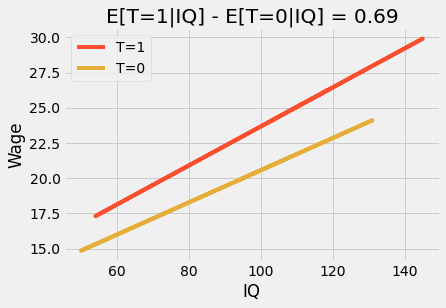

In [ ]:
m = smf.ols('hwage ~ T*IQ', data=wage).fit()
plt_df = wage.assign(y_hat = m.fittedvalues)

plt.plot(plt_df.query("T==1")["IQ"], plt_df.query("T==1")["y_hat"], c="C1", label="T=1")
plt.plot(plt_df.query("T==0")["IQ"], plt_df.query("T==0")["y_hat"], c="C2", label="T=0")
plt.title(f"E[T=1|IQ] - E[T=0|IQ] = {round(m.params['T'], 2)}")
plt.ylabel("Wage")
plt.xlabel("IQ")
plt.legend();

마지막으로 모델의 모든 변수가 더미인 경우를 살펴보겠습니다. 그렇게 하기 위해 우리는 IQ를 4개의 범주로 분리하고 교육 기간을 범주형 변수로 취급합니다.

In [ ]:
wage_ed_bins = (wage
                .assign(IQ_bins = lambda d: pd.qcut(d["IQ"], q=4, labels=range(4)))
                [["hwage", "educ", "IQ_bins"]])

wage_ed_bins.head()

hwage  educ IQ_bins
0  19.225    12       1
1  16.160    18       3
2  20.625    14       2
3  16.250    12       1
4  14.050    11       0

교육 기간을 하나의 범주로 취급하면서, 우리는 더 이상 교육의 효과를 단일 매개 변수로 제한하지 않습니다. 대신, 우리는 각 교육 연도가 고유한 영향을 미치도록 허용합니다. 그렇게 함으로써 교육의 효과가 더 이상 매개변수가 아니기 때문에 유연성을 얻을 수 있습니다. 이 모델은 단순히 각 교육 연도별 평균 임금을 계산합니다.

In [ ]:
model_dummy = smf.ols('hwage ~ C(educ)', data=wage).fit()
model_dummy.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

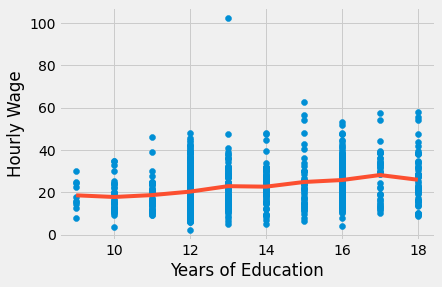

In [ ]:
plt.scatter(wage["educ"], wage["hwage"])
plt.plot(wage["educ"].sort_values(), model_dummy.predict(wage["educ"].sort_values()), c="C1")
plt.xlabel("Years of Education")
plt.ylabel("Hourly Wage");

우선, 이것이 교육이 임금에 어떻게 영향을 미치는지에 대한 함수 형태에 대한 가정을 제거하는 방법에 주목하십시오. 더 이상 로그에 대해 걱정할 필요가 없습니다. 본질적으로, 이 모델은 완전히 비모수적입니다. 그것이 하는 일은 교육의 각 연도에 대한 표본 평균 임금을 계산하는 것뿐입니다. 이것은 적합선이 특정 형태를 갖지 않다는 것을 위의 플롯에서 볼 수 있습니다. 대신, 각 교육 연도에 대한 표본 평균의 보간입니다. 예를 들어, 17년간의 교육 기간 매개변수를 재구성하여도 알 수 있습니다. 이 모델의 경우 `9.5905`입니다. 아래에서, 아래에서 기준 교육 연도(9년)와 17년 개인 간의 차이가 어떻게 되는지 알 수 있습니다.

$
\beta_{17} = E[Y|T=17]-E[Y|T=9]
$

절충점은 우리가 그러한 유연성을 허용할 때 통계적 의미를 잃는다는 것입니다. 몇 년 동안 p-values가 얼마나 큰지 알아보세요.

In [ ]:
t1 = wage.query("educ==17")["hwage"]
t0 = wage.query("educ==9")["hwage"]
print("E[Y|T=9]:", t0.mean())
print("E[Y|T=17]-E[Y|T=9]:", t1.mean() - t0.mean())

E[Y|T=9]: 18.56
E[Y|T=17]-E[Y|T=9]: 9.590472362353516


모델에 더 많은 더미 공변량을 포함하면 교육에 대한 매개 변수는 각 더미 그룹에 대한 효과의 가중 평균이 됩니다.

$
E\{ \ (E[Y_i|T=1, Group_i] - E[Y_i|T=0, Group_i])w(Group_i) \}
$

$w(Group_i)$는 정확히는 아니지만 $Var(T_i|Group_i)$ 그룹의 처치 분산에 비례합니다. 여기서 발생하는 자연스러운 질문 중 하나는 그룹 가중치가 표본 크기인 전체 비모수 추정기를 사용하지 않는 이유는 무엇입니까? 이것은 실제로 유효한 추정량이지만 회귀가 하는 일은 아닙니다. 회귀 분석에서는 처치 분산을 사용함으로써 처치가 많이 달라지는 그룹에 더 많은 가중치를 부여합니다. 이것은 직관적으로 이해가 됩니다. 처치가 거의 일정했다면(예를 들어 1명이 처치되고 나모지 모두 처리되지 않음), 표본 크기는 중요하지 않습니다. 그것은 처치 효과에 대한 많은 정보를 제공하지 않습니다.

In [ ]:
model_dummy_2 = smf.ols('hwage ~ C(educ) + C(IQ_bins)', data=wage_ed_bins).fit()
model_dummy_2.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

![img](https://matheusfacure.github.io/python-causality-handbook/_images/you_little_shit.png)

## Key Ideas

일부 데이터 포인트가 다른 데이터 포인트보다 얼마나 중요한지 살펴보는 것으로 이 섹션을 시작했습니다. 즉, 선형 모형을 추정할 때 표본 크기가 크고 분산이 낮은 표본에 더 많은 가중치를 부여해야 합니다. 그런 다음 모델에 샘플 가중치를 사용하는 경우 선형 회귀가 그룹화된 익명 데이터를 우아하게 처리할 수 있는 방법을 살펴보았습니다.

다음으로 더미 회귀 분석으로 이동했습니다. 우리는 치료가 결과에 어떻게 영향을 미치는지에 대한 함수 형태에 대해 어떠한 가정도 하지 않는 비모수적 모델이 될 수 있는 방법을 보았습니다. 그런 다음 우리는 더미 회귀 분석의 이면에 있는 직관을 탐구했습니다.

## References

저는 이 책을 Joshua Angrist, Alberto Abadie 및 Christopher Walters의 대단한 계량 경제학 수업에 대한 찬사라고 생각하고 싶습니다. 이 자료에 있는 대부분의 아이디어는 전미경제학회(American Economic Association)의 수업에서 가져왔어요. 이렇게 좋은 참고자료를 지켜보는 것이 저의 2020년의 힘든 한 해 동안, 온전한 정신을 유지하도록 도와주었어요.

* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

또한 Angrist의 정말 좋은 책들을 참고자료 목록에 담고 싶습니다. 이 책들은 계량경제학(Econometrics) 또는 '메트릭스(Metrics, 계량적 분석)'가 매우 유용할 뿐만 아니라 매우 재미있다는 것을 저에게 보여주었습니다.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

마지막으로 제가 참고한 자료는 Miguel Hernan과 Jamie Robins의 책입니다. 이 책들은 제가 대답해야 했던 까다로운 인과적인 질문에서 신뢰할 수 있는 동반자와 같은 존재였어요.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

![img](https://matheusfacure.github.io/python-causality-handbook/_images/poetry.png)

## Contribute

Causal Inference for the Brave and True는 인과추론, 통계학에 대한 오픈소스 자료입니다. 이 자료는 금전적으로나 지적으로 접근이 가능할 수 있도록 하는 것이 목표입니다. 그리고, 이 책은 Python 기반의 무료 소프트웨어만 사용해요. 여러분들께서 이 자료가 가치 있다고 생각하시고, 금전적으로 지원을 원하신다면 [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true)를 방문해주세요. 만약 여러분이 금전적으로 기여하기가 쉽지 않으시다면, 오타 수정, 수정 제안, 이해하기 난해한 부분에 대한 피드백 제공 등을 통해 도움을 주실 수 있어요. 이 책의 Github 저장소 [이슈 페이지](https://github.com/matheusfacure/python-causality-handbook/issues)를 방문해주세요. 마지막으로 이 자료가 여러분의 마음에 드셨다면 도움이 될 수 있는 다른 사람들과 공유해주시고, [이 책의 Github 자료에 star](https://github.com/matheusfacure/python-causality-handbook/stargazers) 부탁드립니다!